<a href="https://colab.research.google.com/github/caofengnian/A-MapReduce-practice/blob/master/predict_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Why this dataset

## Problem of former dataset
* No correct label (targets) -  targets (correct answers) known to the organizers
* Can not do evaluation





# Data Stucture

* **bookingID**: trip id
* **Accuracy**: accuracy inferred by GPS in meters
* **Bearing**: GPS bearing
* **acceleration_x**: accelerometer reading in x axis (m/s2)
* **acceleration_y**: accelerometer reading in y axis (m/s2)
* **acceleration_z**: accelerometer reading in z axis (m/s2)
* **gyro_x**: gyroscope reading in x axis (rad/s)
* **gyro_y**: gyroscope reading in y axis (rad/s)
* **gyro_z**: gyroscope reading in z axis (rad/s)
* **second**: time of the record by number of seconds
* **Speed**: speed measured in GPS in m/s


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Goal of Solving the Problem
If the trip is a bad driving, it will be assigned with label 1. Otherwise, it will be assigned as label 0.

In [4]:
data_files = []
label_file = '/content/drive/My Drive/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv'
for f in next(os.walk("/content/drive/My Drive/safety/features/"))[2]:
    if f.endswith("csv") and f != label_file.split("/")[2]:
        data_files.append(f)
tele_data = []
for file in data_files:
    df = pd.read_csv("/content/drive/My Drive/safety/features/" + file)
    tele_data.append(df)
tele_data = pd.concat(tele_data)
label = pd.read_csv(label_file)
tele_data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1194000908341,4.000,203.000000,1.001973,9.745000,-0.790087,-0.066046,0.019175,0.044741,246.0,6.480000
1,1099511627891,3.000,311.000000,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,0.340365
2,962072674446,10.000,142.807999,0.018542,-8.041156,-4.960114,0.004223,-0.014875,0.007397,1552.0,2.050000
3,1142461300867,8.000,171.205292,-0.290698,-8.295367,-3.049042,0.033618,0.046224,0.030559,277.0,17.608448
4,412316860548,19.379,0.000000,0.675613,8.846130,1.852508,-0.008652,0.003693,0.001160,148.0,0.000000


* **It has 20000 trips with 16135561 data points in total.**

# Data Pre-processing


## Check NULL Values
* no empty item

In [5]:
tele_data.isna().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64

In [6]:
label.isna().sum()

bookingID    0
label        0
dtype: int64

In [7]:
print(tele_data.shape)
print('Telematics dataset totla items:', len(tele_data['bookingID'].unique()))
print('label dataset totla items:', len(label))

(16135561, 11)
Telematics dataset totla items: 20000
label dataset totla items: 20018


## Why there are 20018 label targets?
* It has 20018 target items.
* It may have duplicated trips.

In [8]:
dupli_trip = label.loc[label['bookingID'].duplicated(),'bookingID']
for each_bookingID in dupli_trip:
  print(label[label['bookingID'] == each_bookingID])

         bookingID  label
2351  154618822837      1
5295  154618822837      0
          bookingID  label
6168  1279900254294      1
6210  1279900254294      0
          bookingID  label
1256  1511828488211      1
6516  1511828488211      0
          bookingID  label
2858   455266533495      1
10778  455266533495      0
          bookingID  label
6212   223338299461      0
11215  223338299461      1
       bookingID  label
12463         13      0
12602         13      1
          bookingID  label
2721   970662608932      0
13634  970662608932      1
           bookingID  label
1059   1632087572573      1
14432  1632087572573      0
           bookingID  label
9979   1391569403991      0
14942  1391569403991      1
           bookingID  label
9483   1408749273124      0
16340  1408749273124      1
           bookingID  label
3068   1348619731077      1
16990  1348619731077      0
          bookingID  label
10880  695784702084      0
17001  695784702084      1
          bookingID  label
8

## Remove all of them
*  All of them are conflict labels (0 and 1 at the same time). In order to improve data quality and not to influence the prediction model, drop all of them.

In [9]:
tele_data = tele_data[~tele_data['bookingID'].isin(dupli_trip)]
print(tele_data.shape)
label = label[~label['bookingID'].isin(dupli_trip)]
print(label.shape)

(16116704, 11)
(19982, 2)


# Data Cleaning

In [10]:
tele_data.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07,1.611670e+07
mean,8.184342e+11,1.161327e+01,1.689596e+02,6.897958e-02,4.473604e+00,8.958685e-01,-1.708257e-03,2.938396e-04,-2.601239e-04,3.807072e+03,9.006461e+00
std,4.951572e+11,8.696429e+01,1.072970e+02,1.424623e+00,8.128499e+00,3.250204e+00,1.446192e-01,3.402431e-01,1.481542e-01,1.437527e+06,8.106538e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.084229e-01,-1.932755e+00,-9.298957e-01,-2.679162e-02,-2.993423e-02,-1.876969e-02,2.410000e+02,1.020000e+00
50%,8.074539e+11,4.244000e+00,1.687888e+02,6.120300e-02,9.082404e+00,7.769897e-01,-6.420414e-04,2.663161e-04,-3.726278e-05,5.200000e+02,7.530000e+00
75%,1.254130e+12,8.000000e+00,2.629526e+02,6.347809e-01,9.709925e+00,2.751175e+00,2.331571e-02,3.144551e-02,1.823425e-02,8.620000e+02,1.548000e+01
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,1.495797e+09,1.480186e+02


* **Some seconds are incredibly large.**

In [11]:
label.describe()

,bookingID,label
count,1.998200e+04,19982.000000
mean,8.161654e+11,0.249374
std,4.944728e+11,0.432662
min,0.000000e+00,0.000000
25%,3.865471e+11,0.000000
50%,7.988639e+11,0.000000
75%,1.245541e+12,0.000000
max,1.709397e+12,1.000000


In [12]:
label['label'].value_counts()

0    14999
1     4983
Name: label, dtype: int64

* **Around 24.94% is dangerous.**

## Remove counterintuitive data
* 1. 'Speed (m/s)' could be lower than 0. It may represent that it was reversing. But it should not be extremly large.

* 2. 'Second' should not be extremly large.

### Box Plot to Examine Outliers

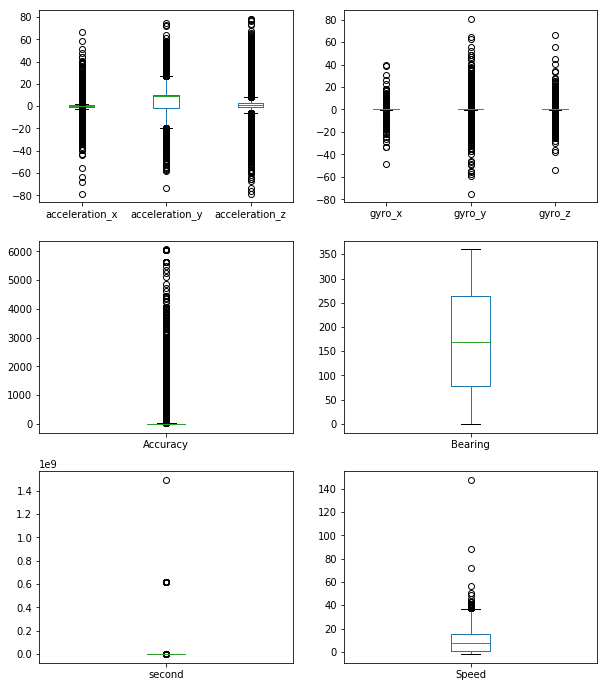

In [13]:
box_fig = plt.figure()

ax0 = box_fig.add_subplot(3, 2, 1)
ax1 = box_fig.add_subplot(3, 2, 2)
ax2 = box_fig.add_subplot(3, 2, 3)
ax3 = box_fig.add_subplot(3, 2, 4)
ax4 = box_fig.add_subplot(3, 2, 5)
ax5 = box_fig.add_subplot(3, 2, 6)

box0 = tele_data[['acceleration_x','acceleration_y','acceleration_z']]
box1 = tele_data[['gyro_x','gyro_y','gyro_z']]
box2 = tele_data[['Accuracy']]
box3 = tele_data[['Bearing']]
box4 = tele_data[['second']]
box5 = tele_data[['Speed']]

box0.plot(kind='box', figsize=(10, 12), ax=ax0)
box1.plot(kind='box', figsize=(10, 12), ax=ax1)
box2.plot(kind='box', figsize=(10, 12), ax=ax2)
box3.plot(kind='box', figsize=(10, 12), ax=ax3)
box4.plot(kind='box', figsize=(10, 12), ax=ax4)
box5.plot(kind='box', figsize=(10, 12), ax=ax5)


plt.show()

### Examine Second Outliers

In [14]:
# examine second
print("Number of extremly large second (>100000000): \n", sum(tele_data['second'] >= 100000000))

Number of extremly large second (>100000000): 
 82


From the box plot, we can see some of the second data is far larger than normal. We should exampt all of them larger than about 0.6e+09, which are larger than 20 years. Others are reasonably below 8000 seconds which are around 2 hours and below.

### Examine Speed Outliers

In [15]:
# examine speed
#print(tele_data['Speed'].describe())
print("Numbers of Speed equals -1: \n", sum(tele_data['Speed']==-1), "\nPercentage of Speed equals -1: \n", sum(tele_data['Speed']==-1)/sum(tele_data['Speed'] <0))
print("Examine extremly large speed: \n", tele_data['Speed'].nlargest(2))

Numbers of Speed equals -1: 
 236923 
Percentage of Speed equals -1: 
 0.9869612127321883
Examine extremly large speed: 
 802096    148.018630
410507     88.037254
Name: Speed, dtype: float64


* 98.6% speed lower than 0 equals -1. It is abnormal. Although the value could be lower than 0, the percentage of being -1 is too high. The reason of it is inferred by GPS accurancy is very low. We can see some of the accuracy is in thousands of meters. Thus the system may indicate these value as -1. Moreover, the largest two speed is around 148 and 88 respectively. 88 m/s (316 km/h) is possible, but 148 m/s (532 km/h) is too large for a vehicle.

### Examine Accuracy

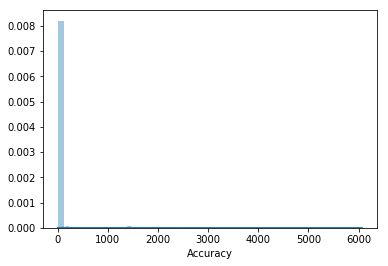

In [16]:
sns.distplot(tele_data['Accuracy'])

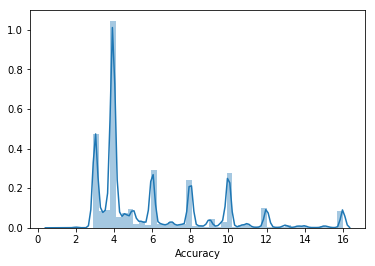

In [17]:
tele_acc = tele_data['Accuracy']
tele_acc = tele_acc.loc[tele_data["Accuracy"] <= np.percentile(tele_data["Accuracy"], 95)]
sns.distplot(tele_acc)

### Clean counterintuitive/outlier data

In [0]:
tele_data = tele_data.loc[(tele_data['second'] < 100000000) & (tele_data['Speed'] < 89) & (tele_data['Speed'] != -1) & (tele_data["Accuracy"] <= np.percentile(tele_data["Accuracy"], 95))]

In [19]:
tele_data.shape

(15419359, 11)

### Drop Accuracy

In [0]:
tele_data.drop(['Accuracy'], axis=1, inplace=True)
# tele_data.head()

## Group by BookingID
* Reduce repeating items would be helpful to the model and prevent overfitting.

# Feature Engineering

## Data Transforming

### Transform Accelerometer and gyroscope
* The two raw series of data are needed to be transformed to useful.

#### Accelerometer
* Real composed direction acceleration $\sqrt{(acceleration_x)^2+(acceleration_y)^2+(acceleration_z)^2}$ 

In [0]:
tele_data['acc'] = np.sqrt((tele_data.loc[:,('acceleration_x', 'acceleration_y', 'acceleration_z')]**2).sum(axis=1))
# tele_data.head()

#### Gyroscope
* It need to be reduce demension from triaxial data (3-D Demension).
* Principal component analysis (PCA) will be used to reduce the risk of curse of dimensionality.

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca_gyro = pca.fit(tele_data.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
pca_gyro.explained_variance_ratio_
tele_data['pca_gyro'] = pca_gyro.transform(tele_data.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])

* gyro_x is 75.86%. Just keep gyro_x.

In [23]:
tele_data.head()

,bookingID,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acc,pca_gyro
0,1194000908341,203.000000,1.001973,9.745000,-0.790087,-0.066046,0.019175,0.044741,246.0,6.480000,9.828185,0.020808
1,1099511627891,311.000000,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,0.340365,9.787368,0.001842
2,962072674446,142.807999,0.018542,-8.041156,-4.960114,0.004223,-0.014875,0.007397,1552.0,2.050000,9.447924,-0.014509
3,1142461300867,171.205292,-0.290698,-8.295367,-3.049042,0.033618,0.046224,0.030559,277.0,17.608448,8.842753,0.048700
5,1176821039217,277.000000,0.268151,9.011775,1.781286,0.000192,0.003718,-0.011833,56.0,1.053419,9.190048,0.002531


In [24]:
tele_data.drop(['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z'], axis=1, inplace=True)
tele_data.head()

,bookingID,Bearing,second,Speed,acc,pca_gyro
0,1194000908341,203.000000,246.0,6.480000,9.828185,0.020808
1,1099511627891,311.000000,66.0,0.340365,9.787368,0.001842
2,962072674446,142.807999,1552.0,2.050000,9.447924,-0.014509
3,1142461300867,171.205292,277.0,17.608448,8.842753,0.048700
5,1176821039217,277.000000,56.0,1.053419,9.190048,0.002531


## Generate Features

In [25]:
data_p = pd.DataFrame()
for col in tele_data.columns:
    if col != "bookingID":
        temp = tele_data.groupby("bookingID")[col].agg(['mean', 'sum', 'max', 'min', 'std'])
        data_p[col + "_mean"] = temp["mean"]
        data_p[col + "_sum"] = temp["sum"]
        data_p[col + "_max"] = temp["max"]
        data_p[col + "_min"] = temp["min"]
        data_p[col + "_std"] = temp["std"]
data_p.head()

,Bearing_mean,Bearing_sum,Bearing_max,Bearing_min,Bearing_std,second_mean,second_sum,second_max,second_min,second_std,Speed_mean,Speed_sum,Speed_max,Speed_min,Speed_std,acc_mean,acc_sum,acc_max,acc_min,acc_std,pca_gyro_mean,pca_gyro_sum,pca_gyro_max,pca_gyro_min,pca_gyro_std
bookingID,,,,,,,,,,,,,,,,,,,,,,,,,
0,176.311276,176663.898315,359.979767,0.037464,129.270716,902.936128,904742.0,1589.0,0.0,534.113894,9.003204,9021.210626,22.946083,0.064309,7.200000,9.883337,9903.103489,12.988328,6.457339,0.619492,-0.006636,-6.649271,0.483770,-0.617404,0.099027
1,126.125298,105693.000000,337.000000,5.000000,89.202934,581.681384,487449.0,1034.0,0.0,289.129088,8.019369,6720.231233,21.882141,0.000000,7.025981,9.865608,8267.379838,12.790147,6.970526,0.522142,-0.006912,-5.792044,0.465017,-0.658963,0.090786
2,173.794872,33890.000000,354.000000,1.000000,119.316520,339.441026,66191.0,825.0,0.0,356.319445,3.157213,615.656528,9.360483,0.000000,2.897762,9.929590,1936.270054,13.403410,8.234988,0.515173,-0.012811,-2.498204,0.433942,-0.462356,0.117118
4,151.807013,166076.872711,353.855377,2.271227,71.273774,547.495430,598960.0,1094.0,0.0,315.962793,6.150996,6729.190006,19.780001,0.000000,5.595901,9.813434,10735.897309,21.053265,7.703982,0.620066,0.022378,24.481480,0.654154,-0.512283,0.112631
6,197.812785,216605.000000,359.000000,0.000000,111.868249,547.000000,598965.0,1094.0,0.0,316.243577,4.628921,5068.669039,16.394695,0.000000,5.314844,9.918090,10860.308906,14.498268,7.218154,0.585346,0.000420,0.460174,0.539158,-0.622273,0.106477


In [26]:
len(data_p)

19934

# Tree-based models to select features
* "dt": DecisionTreeRegressor(),
* "rf": RandomForestRegressor(),
* "ada": AdaBoostRegressor(),
* "gb": GradientBoostingRegressor(),
* "et": ExtraTreesRegressor(),
* "xgb": XGBRegressor(),
* "lgb": LGBMRegressor()

# Linear-based models to select features
* "en": ElasticNet(),
* "hr": HuberRegressor(),
* "lr": LinearRegression(),
* "ridge": Ridge(),
* "lasso": Lasso(),
* "sgd": SGDRegressor(), 
* "pa": PassiveAggressiveRegressor()

In [27]:
label.shape

(19982, 2)

# Evaluation


*   ROC Curves and Area Under the Curve(AUC)
*   ROC more curve is better - Purpose of AUC
*   AUC is close to 0.5 (random guessing). AUC is close to 1 (perfect classifier)
